File for all figures in the paper.

In [26]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import multiprocess as mp

from coin import COIN
from environments import CustomMountainCarEnv
from rl import QLearningAgent, COINQLearningAgent

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Figure 1: Contextualisation and Clustering

## Plot effect of contextual policies on a training environment

In [27]:
# Set scale factors for testing
sf = np.concatenate([
    0.0*np.ones((500, )), 
    1.0*np.ones((500, )),
    1.4*np.ones((500, )),
    0.0*np.ones((500, )),
    1.0*np.ones((500, )),
    1.6*np.ones((500, ))
    ])

train = False # Set to True to train the models, otherwise load saved values

Generate rewards for basic no-context model.

In [ ]:
def run_single_rep(rep_id, sf):
    """
    Runs one repetition of training across all amplitudes in sf.
    Returns the list of rewards.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import QLearningAgent
    # Create a fresh agent and environment inside each process

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = QLearningAgent(
        env=env,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        min_epsilon=0.01
    )

    rewards_for_this_rep = []
    for i, amplitude in enumerate(sf):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, max_steps_per_episode=1000)
        rewards_for_this_rep.append(training_reward)

        if (i + 1) % 500 == 0:
            print(f"Repetition {rep_id}, Amplitude {amplitude}: Training reward = {training_reward}")

    return rewards_for_this_rep

REWARDS_PATH = "models/fig1a_rewards_basic.npy"
if train:
    # Number of repetitions and number of parallel processes:
    n_reps = 100
    n_processes = 17
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_basic = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_basic)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_basic = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

Train COIN Model

In [54]:
# Initialize contextual model from COIN

# We store probability p(c|y,...) here and not p(c|...) where ... are previous values
store = [
    "responsibilities",
    "state_feedback",
]

coin_model = COIN(
    prior_precision_drift=5.0,
    store=store,
    runs=1,
    max_cores=1
) # use default parameters for now
coin_model.perturbations = sf

output = coin_model.simulate_coin()

resp = output["runs"][0]["responsibilities"]
p_context = np.sum(resp, axis=1)
p_context = p_context / np.sum(p_context, axis=0, keepdims=True)

Simulting the COIN model


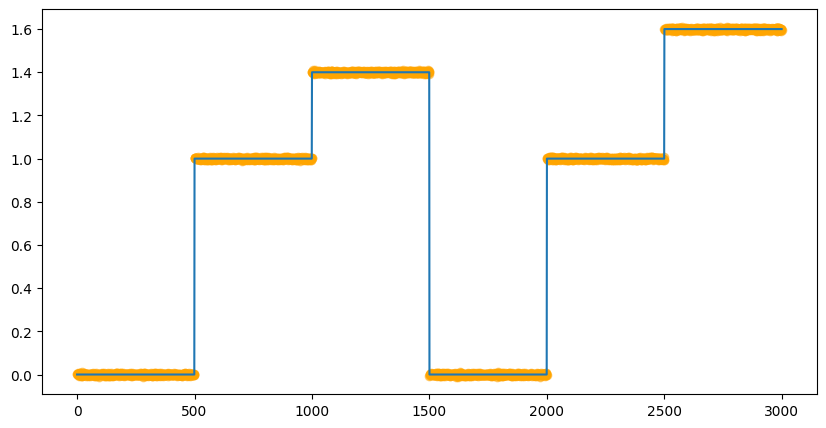

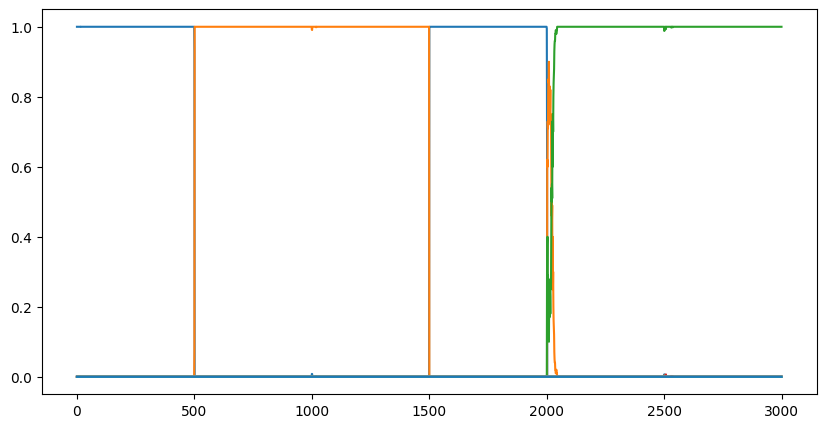

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(sf, label="Amplitude")

state_feedback = output["runs"][0]["state_feedback"]
plt.scatter(
    np.arange(len(sf)), state_feedback, label="State Feedback", color="orange", alpha=0.5
)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(p_context.T, label="p(c|y)")
plt.show()

In [18]:
# Now we train our Q-learning agent (COIN)
# Begin training loop
num_episodes = p_context.shape[1]
C = p_context.shape[0]

# Create the COIN Q-learning agent
env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
agent = COINQLearningAgent(
    env=env,
    max_contexts=C,
    num_position_bins=30,
    num_velocity_bins=30,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.999
)

rewards_coin = []

for i in range(0,num_episodes):
    # Create the MountainCar environment with the true amplitude
    env = CustomMountainCarEnv(amplitude=sf[i], render_mode="none")

    # Train the agent in the current context
    training_reward = agent.train_step(
        env=env,
        p_context=p_context[:,i],
        max_steps_per_episode=1000,
    )

    rewards_coin.append(training_reward)

    # Print the average training reward every 500 episodes
    if ((i+1)%500 == 0):
        print(f"Episode {i+1}, Training reward: {np.mean(rewards_coin[-500:])}")

Episode 500, Training reward: -259.16
Episode 1000, Training reward: -834.844
Episode 1500, Training reward: -968.038
Episode 2000, Training reward: -188.364
Episode 2500, Training reward: -390.384
Episode 3000, Training reward: -744.536


Train Oracle Model

In [21]:
# Oracle model has an agent for each context
env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
agents = [QLearningAgent(
    env=env,
    num_position_bins=30,
    num_velocity_bins=30,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_decay=0.999,
    min_epsilon=0.01
) for _ in range(C)]

true_contexts = np.concatenate([
    np.ones((500, ), dtype=int), 
    2*np.ones((500, ), dtype=int),
    3*np.ones((500, ), dtype=int),
    np.ones((500, ), dtype=int),
    2*np.ones((500, ), dtype=int),
    4*np.ones((500, ), dtype=int)
    ])

rewards_oracle = []

for i in range(0,np.size(sf)):
    # Create the MountainCar environment with the true amplitude
    env = CustomMountainCarEnv(amplitude=sf[i], render_mode="none")

    # Train the agent in the current context
    agent = agents[true_contexts[i]-1]
    training_reward = agent.train_step(
        env=env,
        max_steps_per_episode=1000
    )

    rewards_oracle.append(training_reward)

    # Print the average training reward every 500 episodes
    if ((i+1)%500 == 0):
        print(f"Episode {i+1}, Training reward: {np.mean(rewards_oracle[-500:])}")

Episode 500, Training reward: -259.846
Episode 1000, Training reward: -820.274
Episode 1500, Training reward: -952.63
Episode 2000, Training reward: -173.964
Episode 2500, Training reward: -374.906
Episode 3000, Training reward: -990.66
